In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import NNSingleFeatureModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
from time import time
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/{key}.pkl')
    return raw[key]

In [3]:
def load_sub_model_with_config(train_config, model_configs, sub_model_key, X_count=0, force_recreate=False):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    model_config = model_configs[sub_model_key]
    f = f"{path}/{prefix}{sub_model_key}.pth"
    if os.path.exists(f) and not force_recreate:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        next_epoch = checkpoint['next_epoch']
    else:
        raise Exception('Model does not exist')
    return net, loss_func, optimizer, mean_losses, next_epoch

def save_model_with_config(train_config, sub_model_key, **kwargs):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    f = f"{path}/{prefix}{sub_model_key}.pth"
    torch.save(kwargs, f)

In [4]:
def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    model.eval()
    X_tensor = torch.from_numpy(X.to_numpy()).float()
    nn_results = model(X_tensor).detach().numpy()
    return nn_results

In [5]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [6]:
train_config = {
    'dataset' : 'sample2_', # '', 'sample_', 'secret_'
    'model_prefix' : "TRY_2_", 
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t5_models",
    'device' : 'cpu',
}

In [7]:
%%time
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=train_config['dataset'],validation=True)).dropna()
ref_test, X_test, y_test = get_ref_X_y(test_df)
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']
y_test = y_test[y_cols]

Loading data to cache for: sample2_test
CPU times: user 1.38 s, sys: 1.45 s, total: 2.83 s
Wall time: 2.24 s


In [8]:
model_configs = {
    'y_INCLINATION': { 'feature_index': X_test.columns.get_loc('X_INCLINATION_1') },
    'y_ECCENTRICITY': { 'feature_index': X_test.columns.get_loc('X_ECCENTRICITY_1') },
    'y_MEAN_MOTION': { 'feature_index': X_test.columns.get_loc('X_MEAN_MOTION_1') },
    'y_RA_OF_ASC_NODE_REG': { 'feature_index': X_test.columns.get_loc('X_RA_OF_ASC_NODE_1') },
    'y_ARG_OF_PERICENTER_REG': { 'feature_index': X_test.columns.get_loc('X_ARG_OF_PERICENTER_1') },
    'y_REV_MA_REG': { 'feature_index': X_test.columns.get_loc('X_MEAN_ANOMALY_1') },
}

Loading existing model


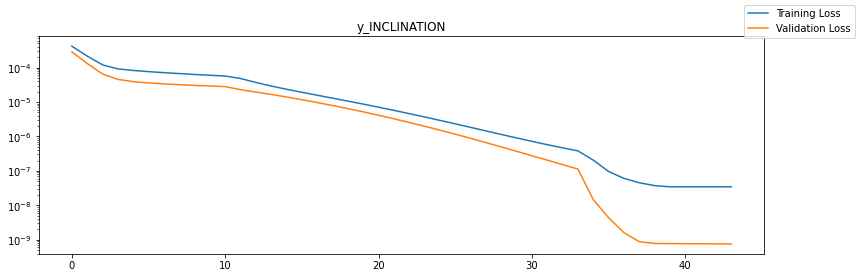

Epoch 44
    Test set MAE (L1) loss: 2.1616366561783312e-05
    Test set MSE (L2) loss: 1.1287032849081218e-09
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):
Loading existing model


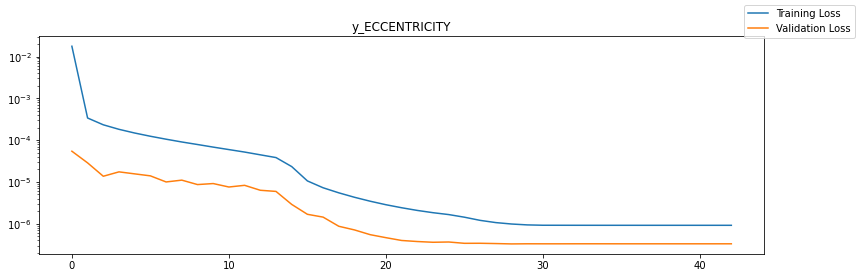

Epoch 43
    Test set MAE (L1) loss: 0.0003700013379225426
    Test set MSE (L2) loss: 6.854108073643192e-07
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):
Loading existing model
No data for y_MEAN_MOTION
Loading existing model
No data for y_RA_OF_ASC_NODE_REG
Loading existing model
No data for y_ARG_OF_PERICENTER_REG
Loading existing model


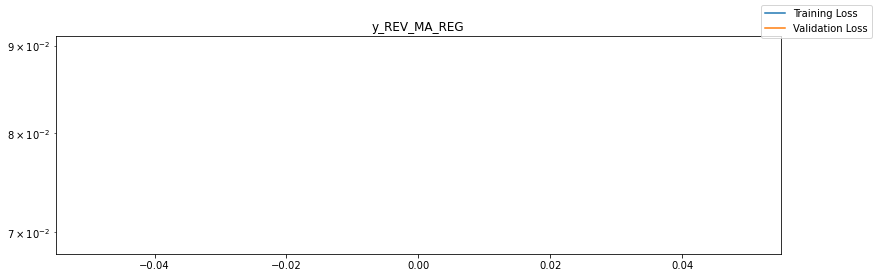

Epoch 1
    Test set MAE (L1) loss: 0.2929225971156531
    Test set MSE (L2) loss: 0.09987203059035253
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):


,y_INCLINATION,y_INCLINATION,X_INCLINATION_1,y_ECCENTRICITY,y_ECCENTRICITY,X_ECCENTRICITY_1,y_REV_MA_REG,y_REV_MA_REG,X_MEAN_ANOMALY_1
22115,0.3462138889,0.3462332785,0.3462116667,0.2406920,0.2404569387,0.2404968,0.7783453426,0.6027923226,0.0537513889
1195160,0.5495638889,0.5496042371,0.5495638889,0.0043288,0.0043455297,0.0043372,0.2125937809,0.0526036769,0.1208719444
616164,0.4611561111,0.4611638188,0.4611616667,0.0290512,0.0291646551,0.0292544,1.3721018148,1.1564577818,0.3320222222
661545,0.4620966667,0.4620801806,0.4620783333,0.0560352,0.0565298572,0.0566204,1.3566146481,1.1618616581,0.0310163889
693120,0.4620500000,0.4620504379,0.4620633333,0.0507388,0.0496840775,0.0498124,1.8171607006,1.5496140718,0.4475816667
...,...,...,...,...,...,...,...,...,...
302757,0.4606377778,0.4606392384,0.4606422222,0.0216860,0.0214471016,0.0215500,1.5302878395,1.0980747938,0.6503033333
43649,0.3459855556,0.3460076749,0.3459955556,0.1240436,0.1237622499,0.1238264,1.1234825525,0.9615787268,0.1188058333
629350,0.4611244444,0.4611258209,0.4611288889,0.0296872,0.0295360684,0.0296392,1.5259797438,1.3503038883,0.2583269444
1143846,0.4112816667,0.4112868309,0.4112838889,0.0088216,0.0089279534,0.0090156,1.4199929722,1.2142392397,0.0429077778


In [11]:
# Create or load all new sub models here if needed.
sample_idx = random.sample(list(X_test.index), 10000)
# sample_idx = X_test.index
all_models = {}
display_data = []
for sub_key in y_cols:
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key)
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)
    try:
        tl, vl = zip(*mean_losses)
    except:
        print(f"No data for {sub_key}")
        continue

    fig,ax = plt.subplots(figsize=(13,4))
    ax.plot(tl, label="Training Loss")
    ax.plot(vl, label="Validation Loss")
    ax.set_title(sub_key)
#     print(ax.get_ylim())
    ax.set_yscale('log')
    ax.set_ylim((ax.get_ylim()[0], min(1,ax.get_ylim()[1])))
    fig.legend()
    plt.show()
    
    trained_model = model
    X_sample = X_test.loc[sample_idx]
    y_sample = y_test.loc[sample_idx][[sub_key]]
    y_sample_pred = predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
    y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe
    print(f'Epoch {next_epoch}')
    print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
    print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')
    print("Test - Ground Truth (normalized):")
#     display(y_sample)
    print("Test - Prediction (normalized):")
#     display(y_sample_pred_df)
    print("Test - X (normalized):")
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
    display_data.append(y_sample)
    display_data.append(y_sample_pred_df)
    display_data.append(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1].values - y_sample_pred_df.values)
#     print(mean_losses[-5:])
    
df = pd.concat(display_data, axis=1)
display(df)

AdamW optimizer
Decrease learning rate slowly over time
Decrease weight decay if both training and validation are decreasing similarly